In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import pandas as pd
from tensorflow import keras
import zipfile
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# geting image data
zip_folder = zipfile.ZipFile('/content/drive/MyDrive/spectogram.zip','r')
zip_folder.extractall()
zip_folder.close()

dir_name = ['spectrogram_air','spectrogram_nomex','spectrogram_teflon']
data = [ os.listdir(os.path.join('/content/spectrogram_jpg/',i)) for i in dir_name ]

import random
sample = []
for ind,files in enumerate(data):
  if ind == 1:
    l1 = random.sample(files,120)
    sample.append(l1)
  elif ind == 2:
    l1 = random.sample(files,35)
    sample.append(l1)
  else:
    l1 = random.sample(files,96)
    sample.append(l1)
sample

[[' Air (51).jpg',
  ' Air (66).jpg',
  ' Air (55).jpg',
  ' Air (43).jpg',
  ' Air (57).jpg',
  ' Air (27).jpg',
  ' Air (36).jpg',
  ' Air (72).jpg',
  ' Air (23).jpg',
  ' Air (74).jpg',
  ' Air (2).jpg',
  ' Air (39).jpg',
  ' Air (71).jpg',
  ' Air (91).jpg',
  ' Air (95).jpg',
  ' Air (64).jpg',
  ' Air (94).jpg',
  ' Air (45).jpg',
  ' Air (73).jpg',
  ' Air (37).jpg',
  ' Air (69).jpg',
  ' Air (30).jpg',
  ' Air (89).jpg',
  ' Air (60).jpg',
  ' Air (81).jpg',
  ' Air (25).jpg',
  ' Air (11).jpg',
  ' Air (15).jpg',
  ' Air (50).jpg',
  ' Air (5).jpg',
  ' Air (46).jpg',
  ' Air (92).jpg',
  ' Air (83).jpg',
  ' Air (9).jpg',
  ' Air (67).jpg',
  ' Air (16).jpg',
  ' Air (48).jpg',
  ' Air (7).jpg',
  ' Air (21).jpg',
  ' Air (77).jpg',
  ' Air (14).jpg',
  ' Air (53).jpg',
  ' Air (56).jpg',
  ' Air (6).jpg',
  ' Air (38).jpg',
  ' Air (1).jpg',
  ' Air (63).jpg',
  ' Air (52).jpg',
  ' Air (75).jpg',
  ' Air (54).jpg',
  ' Air (13).jpg',
  ' Air (35).jpg',
  ' Air (18).jpg',

In [4]:
# # splitting the sample data and making train, test dirs
train_dir = 'spectrogram_sample/train_data'
test_dir = 'spectrogram_sample/test_data'
[os.makedirs(os.path.join('spectrogram_sample/train_data/',i),exist_ok = True) for i in dir_name]
[os.makedirs(os.path.join('spectrogram_sample/test_data/',i),exist_ok = True) for i in dir_name]

train_data_air, test_data_air = train_test_split(sample[0],test_size=0.2,random_state=123)
train_data_nomex, test_data_nomex = train_test_split(sample[1],test_size=0.2,random_state=123)
train_data_teflon, test_data_teflon = train_test_split(sample[2],test_size=0.2,random_state=123)

train_data_img = [train_data_air,train_data_nomex,train_data_teflon]
test_data_img = [test_data_air,test_data_nomex,test_data_teflon]

In [5]:
len(train_data_img[1]),len(sample)

(96, 3)

In [6]:
# adding img to train, test folder
for d_n,train_data in zip(dir_name,train_data_img):
  for f_n in (train_data):
    img = Image.open(os.path.join('/content/spectrogram_jpg',d_n,f_n))
    img.save(os.path.join('/content/spectrogram_sample/train_data',d_n,f_n))

# adding img to train, test folder
for d_n,test_data in zip(dir_name,test_data_img):
  for file1 in (test_data):
    img = Image.open(os.path.join('/content/spectrogram_jpg/',d_n,file1))
    img.save(os.path.join('/content/spectrogram_sample/test_data/',d_n,file1))

In [7]:
# len(os.listdir('/content/spectrogram_sample/test_data/spectrogram_teflon'))
# # creating callbeck
# checkpoint_path = 'model_checkpoint_weight/checkpoint.ckpt'

# callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
#                                                          save_weights_only = True,
#                                                          save_best_only = False,
#                                                          save_freq = 'epoch' )


In [8]:
from tensorflow.keras import layers

train_data = keras.preprocessing.image_dataset_from_directory(train_dir,
                                                             batch_size = 32,
                                                             image_size = (224,224),
                                                             label_mode = 'categorical')

test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             batch_size = 32,
                                                             image_size = (224,224),
                                                             label_mode = 'categorical')

data_augmantation = keras.Sequential([
    layers.RandomFlip(mode = 'horizontal'),
    layers.RandomRotation(20),
    layers.RandomBrightness(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

Found 200 files belonging to 3 classes.
Found 51 files belonging to 3 classes.


In [9]:
# creating base_model and layers
inputs = keras.Input(shape = (224,224,3))
base_model = keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = True
layers = base_model.layers
for layer in layers[:-123]:
  layer.trainable = False

# Put data_augmantation in sequential,base_model,globelaveragepooling2d, and a dense layer on as the output

x = data_augmantation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(3,activation = 'softmax')(x)

# creating model
model_1 = tf.keras.Model(inputs,outputs)

# compiling model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                metrics = ['accuracy'])


16705208/16705208 [==============================] - 0s 0us/step


In [10]:
# fitting the model
history_1 = model_1.fit(train_data,
                        epochs = 50,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        # callbacks = [callback_checkpoint]
                        )

Epoch 1/50
7/7 [==============================] - 35s 867ms/step - loss: 0.9609 - accuracy: 0.5400 - val_loss: 0.9357 - val_accuracy: 0.5686
Epoch 2/50
7/7 [==============================] - 2s 193ms/step - loss: 0.5903 - accuracy: 0.6850 - val_loss: 0.6969 - val_accuracy: 0.5882
Epoch 3/50
7/7 [==============================] - 2s 203ms/step - loss: 0.4742 - accuracy: 0.7400 - val_loss: 0.6342 - val_accuracy: 0.6078
Epoch 4/50
7/7 [==============================] - 3s 310ms/step - loss: 0.4460 - accuracy: 0.7700 - val_loss: 1.0752 - val_accuracy: 0.5882
Epoch 5/50
7/7 [==============================] - 2s 195ms/step - loss: 0.5043 - accuracy: 0.7550 - val_loss: 0.5850 - val_accuracy: 0.6863
Epoch 6/50
7/7 [==============================] - 2s 199ms/step - loss: 0.4688 - accuracy: 0.7650 - val_loss: 2.0944 - val_accuracy: 0.6078
Epoch 7/50
7/7 [==============================] - 2s 195ms/step - loss: 0.4020 - accuracy: 0.8050 - val_loss: 1.9385 - val_accuracy: 0.5686
Epoch 8/50
7/7 [===

<Axes: >

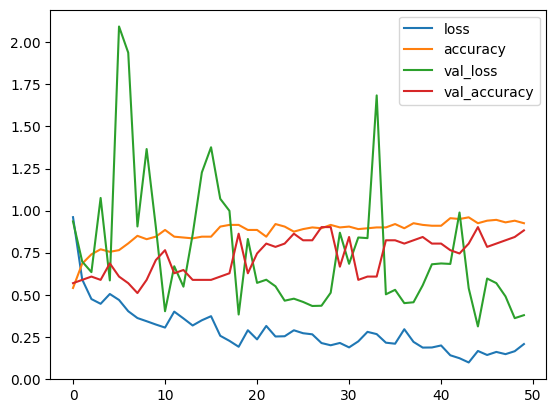

In [11]:
pd.DataFrame(history_1.history).plot()
# history_1.history.values()
# model_1.save('spe_model_test_88p.h5')

In [12]:
# # making prediction on whole data
answer = {'spectrogram_air':[],'spectrogram_nomex':[],'spectrogram_teflon':[]}
dir_list_name = ['spectrogram_air','spectrogram_nomex','spectrogram_teflon']
dir_list = [ os.listdir(os.path.join('/content/spectrogram_jpg/',i)) for i in dir_list_name]
for dir,dir_name in zip(dir_list,dir_list_name):
  for filename in dir:
    img = Image.open(os.path.join('/content/spectrogram_jpg',dir_name,filename))
    img = img.resize((224,224))
    img_arr = tf.expand_dims(np.array(img),axis = 0)
    ans = model_1.predict(img_arr,verbose = 0)
    # answer[dir_name].append(list(map(int,ans.squeeze().tolist())))
    answer[dir_name].append(ans.squeeze().tolist())

In [13]:
# # train_data.num_classes
# class_names = list(train_data.class_indices.keys())
# class_names.sort()
# print("Class Names:", class_names)

# train_data.num_classes
class_names = dir_list_name
class_names.sort()
print("Class Names:", class_names)

Class Names: ['spectrogram_air', 'spectrogram_nomex', 'spectrogram_teflon']


In [14]:
# creatung labels
result = {'spectrogram_air':[],'spectrogram_nomex':[],'spectrogram_teflon':[]}
for keys,val in answer.items():
  for d_val  in val:
    ind = d_val.index(max(d_val))
    pred = class_names[ind]
    result[keys].append(pred)
# result

In [15]:
accuracy = {'spectrogram_air':[],'spectrogram_nomex':[],'spectrogram_teflon':[]}
for keys,val in result.items():
   acc = val.count(keys)
   accuracy[keys].append(acc)
   accuracy[keys].append(len(val))
   accuracy[keys].append(acc/len(val))

# accuracy

In [16]:
accuracy_mat = pd.DataFrame(accuracy).T.set_axis(['Total_predictions','Total_orginals','accuracy'],axis=1)
accuracy_mat

,Total_predictions,Total_orginals,accuracy
spectrogram_air,90.0,96.0,0.937500
spectrogram_nomex,141.0,148.0,0.952703
spectrogram_teflon,131.0,131.0,1.000000


In [17]:
a = accuracy_mat['Total_predictions'].sum()
b = accuracy_mat['Total_orginals'].sum()
accuracy = (a/b)*100
accuracy

96.53333333333333

In [18]:
model_1.save(f'spe_model_test_{str(accuracy)}p.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


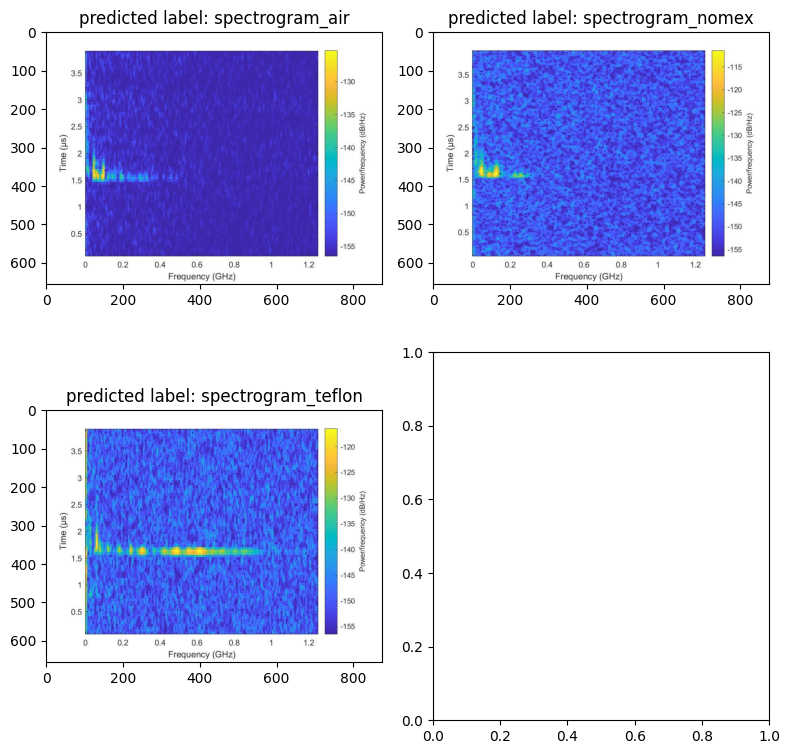

In [19]:
# import random
images = [random.sample(os.listdir(os.path.join('/content/spectrogram_sample/test_data/',i)),1) for i in dir_list_name]

fig, ax = plt.subplots(2,2, figsize = (8,8))
ax = ax.flatten()
a=0


for dir,file in zip(dir_list_name,images):
  for img in file:
    img = os.path.join('/content/spectrogram_sample/test_data',dir,img)
    img = Image.open(img)
    ind = model_1.predict(tf.expand_dims(np.array(img.resize((224,224))),axis=0),verbose=0)
    ind = ind.squeeze().tolist()
    label = class_names[ind.index(max(ind))]
    ax[a].imshow(img)
    ax[a].set_title(f'predicted label: {label}')
    a+=1

plt.tight_layout()
plt.show()
# dir_list_name